In [1]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 11.9MB 3.7MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 24.3MB 1.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 21.5MB 89.6MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 6.4MB 3.4MB/s 
     |████████████████████████████████| 194kB 4.2MB/s 
     |████████████████████████████████| 235kB 7.8MB/s 
     |████████████████████████████████| 2.2MB 7.5MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp36-none-any.whl size=322720 sha256=0fe3c6cbd578853c8d5c1f01557d8f65fcedec3d27765b04507c9c7fe03de335
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011a33

In [2]:
import torch
import numpy as np
import networkx as nx
import community as community_louvain
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
from decimal import Decimal
import timeit

In [3]:
def print_graph(graph, labels, title=None):
  ax = plt.figure(figsize=(10, 10)).gca()
  nx.draw_networkx(graph, with_labels=False, node_color=labels, cmap="Set3", ax=ax)
  if title:
    _ = ax.set_title(title)

In [4]:
class KarateClub(InMemoryDataset):

    def __init__(self, transform=None):
        super(KarateClub, self).__init__('.', transform, None, None)

        G = nx.karate_club_graph()

        x = torch.eye(G.number_of_nodes(), dtype=torch.float)

        adj = nx.to_scipy_sparse_matrix(G).tocoo()
        row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
        col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
        edge_index = torch.stack([row, col], dim=0)

        # Compute communities.
        y = [param['club'] for _, param in G.nodes().items()]
        class_map = {class_name: index for index, class_name in enumerate(np.unique(y))}
        y = list(map(lambda val: class_map[val], y))
        y = torch.from_numpy(np.array(y))

        # Select a single training node for each community
        # (we just use the first one).
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for i in range(int(y.max()) + 1):
            train_mask[(y == i).nonzero(as_tuple=False)[0]] = True

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

        self.data, self.slices = self.collate([data])

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [5]:
dataset = KarateClub()
data = dataset[0]

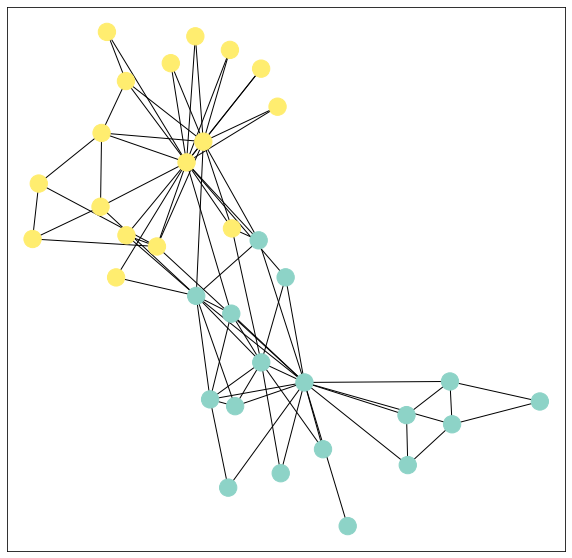

In [6]:
print_graph(to_networkx(data, to_undirected=True), data.y)

In [7]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 2


In [8]:
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 2
Training node label rate: 0.06
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [9]:
import torch
from torch.nn import ReLU, Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        # torch.manual_seed(12345)
        self.layer1 = GCNConv(dataset.num_features, 34)
        self.activation1 = ReLU()
        self.layer2 = GCNConv(34, 34)
        self.activation2 = ReLU()
        self.layer3 = GCNConv(34, 2)
        self.activation2 = ReLU()

    def forward(self, x, edge_index):
        h = self.layer1(x, edge_index)
        h = self.activation1(h)
        h = self.layer2(h, edge_index)
        h = self.activation2(h)
        h = self.layer3(h, edge_index)
        return h

model = GCN()
print(model)

GCN(
  (layer1): GCNConv(34, 34)
  (activation1): ReLU()
  (layer2): GCNConv(34, 34)
  (activation2): ReLU()
  (layer3): GCNConv(34, 2)
)


In [10]:
int(np.array(1))

1

In [11]:
def train(model, data, step_num=500, print_frequency=None):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  losses, accuracies = [], []

  for i in range(step_num):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    predicted = np.argmax(out.detach().numpy(), axis=1)
    loss = criterion(out, data.y)
    accuracy = np.mean(predicted == data.y.numpy())
    loss.backward()
    optimizer.step()
    losses.append(loss)
    accuracies.append(accuracy)
    if print_frequency and (i % print_frequency == 0 or i == step_num - 1):
      print_graph(
        to_networkx(data, to_undirected=True), 
        predicted, 
        title='Step: %d, Loss: %.2E, Accuracy: %.2E' % (i, Decimal(float(loss.detach().numpy())), Decimal(accuracy))
      )       
  return losses, accuracies

2.039966846999988


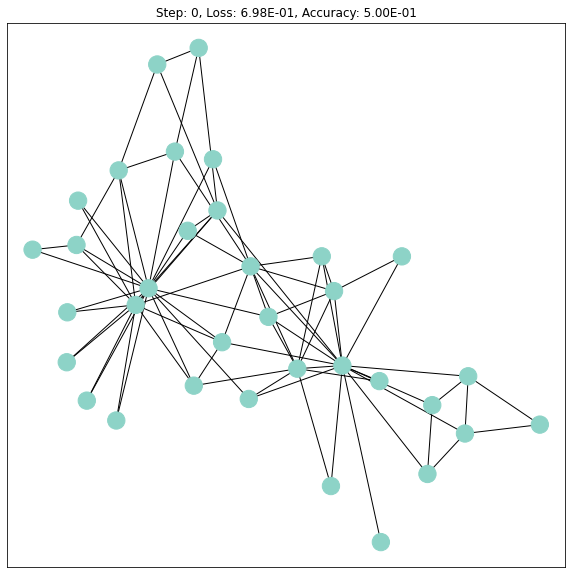

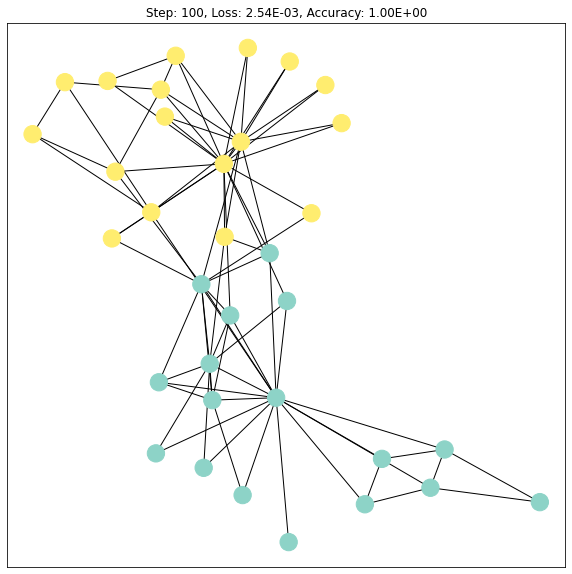

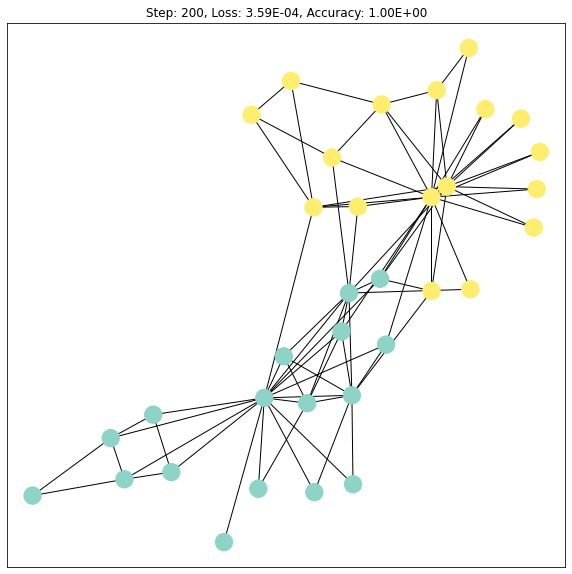

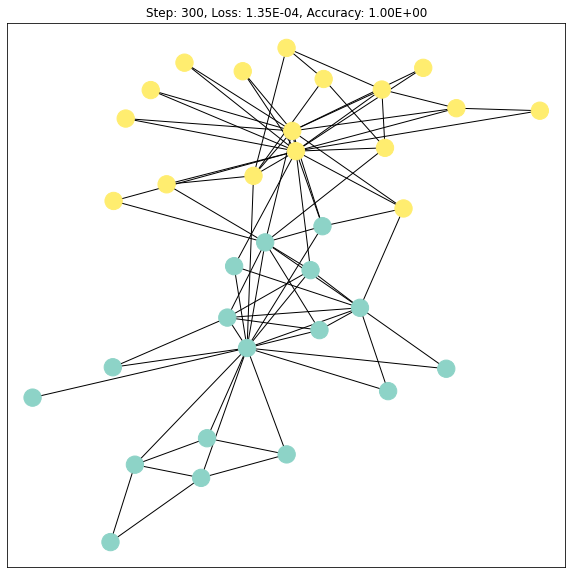

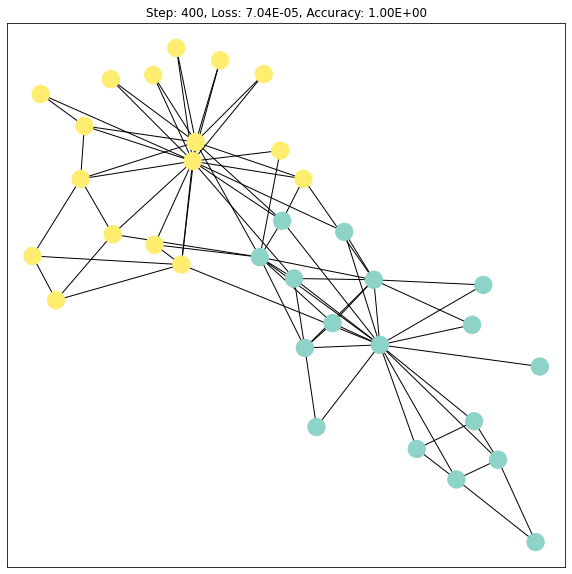

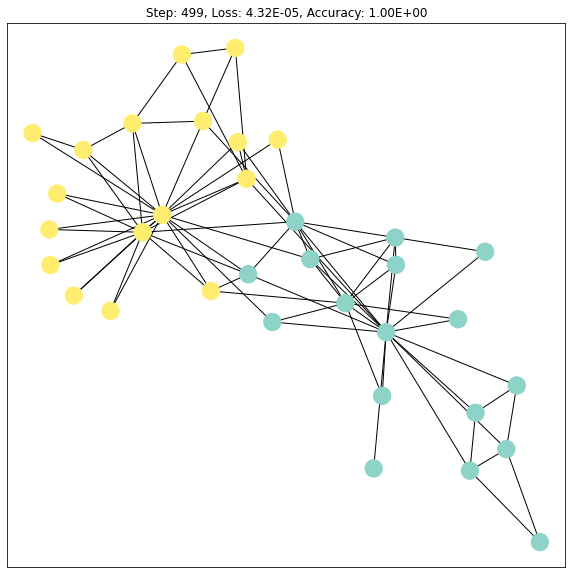

In [12]:
starttime = timeit.default_timer()
losses, accuracies = train(GCN(), data, print_frequency=100)
print(timeit.default_timer()- starttime) 

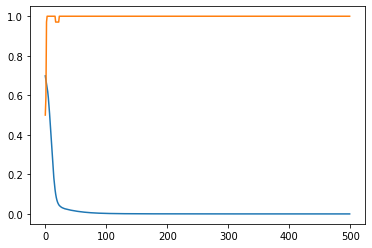

In [13]:
plt.plot(list(zip(losses, accuracies)))

In [14]:
losses, accuracies = [], []

for i in range(25):
  train_losses, train_accuracies = train(GCN(), data)
  losses.append(train_losses)
  accuracies.append(train_accuracies)

losses = np.array(losses)
accuracies = np.array(accuracies)

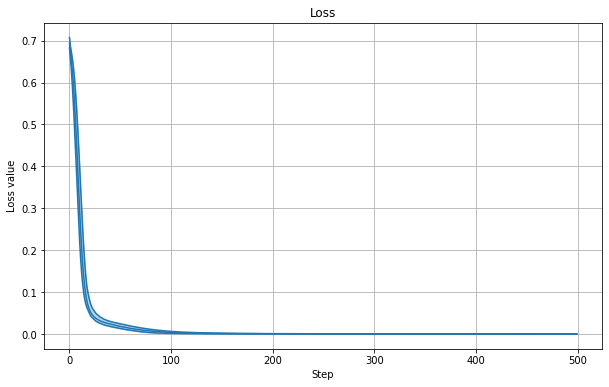

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
max_values = np.array(np.max(losses, axis=0), dtype=float)
min_values = np.array(np.min(losses, axis=0), dtype=float)
mean_values = np.array(np.mean(losses, axis=0), dtype=float)

x = np.arange(0, losses.shape[1])
ax.plot(x, max_values, color="tab:blue")
ax.plot(x, min_values, color="tab:blue")
ax.plot(x, mean_values, color="tab:blue")
ax.fill_between(x, min_values, max_values, color="tab:blue", alpha=0.3)
ax.set_title("Loss")
ax.set_xlabel("Step")
ax.set_ylabel("Loss value")
ax.grid()

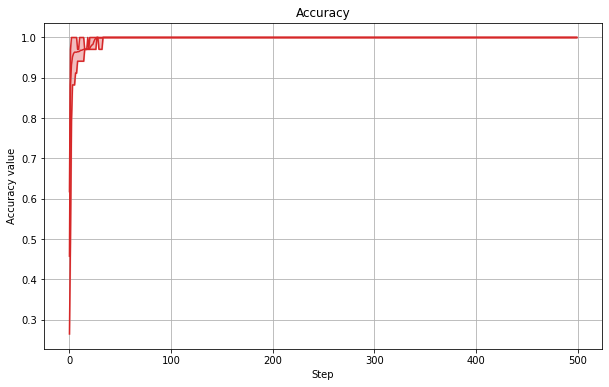

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
max_values = np.array(np.max(accuracies, axis=0), dtype=float)
min_values = np.array(np.min(accuracies, axis=0), dtype=float)
mean_values = np.array(np.mean(accuracies, axis=0), dtype=float)

x = np.arange(0, accuracies.shape[1])
ax.plot(x, max_values, color="tab:red")
ax.plot(x, min_values, color="tab:red")
ax.plot(x, mean_values, color="tab:red")
ax.fill_between(x, min_values, max_values, color="tab:red", alpha=0.3)
ax.set_title("Accuracy")
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy value")
ax.grid()